In [ ]:
#retrive ERA5 pressure levels data from cds.climate.copernicus 
import cdsapi
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'variable': [
            'geopotential', 'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '200', '500', '700',
            '850',
        ],
        'year': '2016',
        'month': '07',
        'day': [
            '07', '08',
            '09',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            -10, -90, -40,
            -60,
        ],
    },
    'atacama_072016_geopotential_wind.grib')

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cfgrib
import cartopy.crs as ccrs
import cartopy
from astropy.constants import g0
import math
import gif

%matplotlib inline

In [2]:
ds = xr.open_dataset('atacama_072016_geopotential_wind.grib', engine='cfgrib')

In [3]:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:        (isobaricInhPa: 4, latitude: 121, longitude: 121, time: 72)
Coordinates:
    number         int64 ...
  * time           (time) datetime64[ns] 2016-07-07 ... 2016-07-09T23:00:00
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) int64 850 700 500 200
  * latitude       (latitude) float64 -10.0 -10.25 -10.5 ... -39.5 -39.75 -40.0
  * longitude      (longitude) float64 -90.0 -89.75 -89.5 ... -60.5 -60.25 -60.0
    valid_time     (time) datetime64[ns] ...
Data variables:
    z              (time, isobaricInhPa, latitude, longitude) float32 ...
    u              (time, isobaricInhPa, latitude, longitude) float32 ...
    v              (time, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    instituti

In [4]:
print(g0)

  Name   = Standard acceleration of gravity
  Value  = 9.80665
  Uncertainty  = 0.0
  Unit  = m / s2
  Reference = CODATA 2018


In [5]:
# convert the geopotential to geopotential height
args = {'name':'geopotential_height',
        'units': 'm'}
ds['geopot_height'] = ds.z/g0
ds.geopot_height.attrs = args

In [6]:
def wind_direction(u,v):
    '''Compute the wind direction from u and v-components.

    Parameters
    ----------
    u : 2D, 1D array or float point
        Wind component in the X (East-West) direction
    v : 2D, 1D array or float point
        Wind component in the Y (North-South) direction

    Returns
    -------
    wind direction: 2D, 1D array or float point
        Direction of wind towards.
    '''
    wdir = 90 - math.atan2(v,u) * 180/np.pi #must cross check; 270 - math.atan2 for wind direction 'from'
    
    return wdir


def wind_speed_direction(u,v):
    '''Compute the wind speed and direction from u and v-components.

    Parameters
    ----------
    u : 2D, 1D array or float point
        Wind component in the X (East-West) direction
    v : 2D, 1D array or float point
        Wind component in the Y (North-South) direction

    Returns
    -------
    wind speed: 2D,1D array or float point
        Speed of the wind
    wind direction: 2D, 1D array or float point
        Direction of wind towards.
    '''
    speed = np.sqrt(u * u + v * v)
    w_direction = np.vectorize(wind_direction)
    wdir = w_direction(u,v)
    
    return speed, wdir

In [7]:
# compute the wind speed and direction
ws, wdir = wind_speed_direction(ds['u'], ds['v'])

In [8]:
# add the variables to the dataset and assign dimensions and coordinates
time = ds['time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values
isobar = ds['isobaricInhPa'].values

wspeed = xr.DataArray(ws, coords={'time': time, 
                                  'isobaricInhPa': isobar,
                                  'latitude': lat, 
                                  'longitude': lon
                                 },
             dims=['time', 'isobaricInhPa', 'latitude', 'longitude'])

wdirection = xr.DataArray(wdir, coords={'time': time, 
                                  'isobaricInhPa': isobar,
                                  'latitude': lat, 
                                  'longitude': lon
                                 },
             dims=['time', 'isobaricInhPa', 'latitude', 'longitude'])

In [9]:
# add variable attributes
args1 = {'name':'wind_speed',
        'units': 'm/s'}
args2 = {'name':'wind_direction',
        'units': 'cardinal'}
ds['wind_speed'] = wspeed
ds['wind_direction'] = wdirection
ds.wind_speed.attrs = args1
ds.wind_direction.attrs = args2

In [10]:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:         (isobaricInhPa: 4, latitude: 121, longitude: 121, time: 72)
Coordinates:
    number          int64 ...
  * time            (time) datetime64[ns] 2016-07-07 ... 2016-07-09T23:00:00
    step            timedelta64[ns] ...
  * isobaricInhPa   (isobaricInhPa) int64 850 700 500 200
  * latitude        (latitude) float64 -10.0 -10.25 -10.5 ... -39.5 -39.75 -40.0
  * longitude       (longitude) float64 -90.0 -89.75 -89.5 ... -60.25 -60.0
    valid_time      (time) datetime64[ns] ...
Data variables:
    z               (time, isobaricInhPa, latitude, longitude) float32 14706....
    u               (time, isobaricInhPa, latitude, longitude) float32 1.0796...
    v               (time, isobaricInhPa, latitude, longitude) float32 5.8058...
    geopot_height   (time, isobaricInhPa, latitude, longitude) float32 1499.6...
    wind_speed      (time, isobaricInhPa, latitude, longitude) float32 5.9053...
    wind_direction  (time, isobaricInhPa, latitude, 

In [11]:
@gif.frame
def plot(i=500, j='2016-07-08T00', t=0, steps = 5, format_time = False):
    '''Plot the geopotential height in dams, wind speed and wind direction.
    
    Parameters:
    -----------
    i      :  int
              Pressure level. Default is 500 hPa
    j      :  datetime[ns] 
              Time stamp for which the geopotential height and wind speed and direction are plotted. 
              Default is '2016-07-08T00'
    t      :  int
              DataArray index to print the time stamp in the correct format in the figure title. Default is 0. 
              Increment t in a for loop. See example for gifs. 
              Do not use for single plots unless the right array index is known.
    steps  :  int
              Interval to plot geopotential height contours. Default is 5.
    format_time: bool
                 Format the displayed time on figure. Default is False as index, t is required to get the correct
                 time stamp. 
              
    Returns:
    ----------
    plot with geopotential height contours in dams (decameters), wind speed as filled contours and normalized
    wind direction vectors. 
    
    '''
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()

    #plot the geopotential height contour lines
    ming = int(np.min(ds['geopot_height'].sel(isobaricInhPa = i).values)/10) #use dam units for geopotential height
    maxg = int(np.max(ds['geopot_height'].sel(isobaricInhPa = i).values)/10)
        
    cs = plt.contour(ds.longitude, ds.latitude, 
                     ds['geopot_height'].sel(isobaricInhPa = i,time=j)/10,
                     levels=np.arange(ming, maxg, steps), colors='grey')
    cs.clabel(fontsize=12, inline=1, fmt='%.f')

    #plot the wind speed using contour fill
    colors=["#f7fcf0","#f2faea","#ecf7e5","#e6f5df","#dff3da","#daf1d5","#d5efcf","#d0edc9",
            "#caeac4","#c1e6bf","#b8e3bb","#aedfb7","#a3dcb6","#96d8ba","#8ad3be","#80cec2",
            "#73c9c6","#64c3ca","#58bdce","#50b6d2","#47add0","#3da3cb","#3499c5","#2c8fc0",
            "#2285bb","#167cb7","#0c73b2","#0869ad","#085fa2","#085497","#084a8c","#084081"
           ] # https://react-colorscales.getforge.io/ for color hex codes; cmap='GnBu'
    levels = list(np.arange(0,33,1))
    
    cw = plt.contourf(ds.longitude, ds.latitude, ds['wind_speed'].sel(isobaricInhPa = i,time=j),
                      colors=colors, levels=levels, extend='max')
    plt.colorbar(cw, shrink=0.8, label=r'ms$^{-1}$')
    cw.cmap.set_over("#084081")

    #plot the wind direction as quivers
    coarse_ds = ds.sel(latitude=np.arange(-40, -10, 3), 
                       longitude=np.arange(-90, 60, 3), 
                       method='nearest') # coarser resolution for well-spaced quivers
    wind_speed = coarse_ds['wind_speed'].sel(isobaricInhPa = i,time=j)
    
    plt.quiver(coarse_ds.longitude, coarse_ds.latitude, 
               coarse_ds['u'].sel(isobaricInhPa = i, time=j)/wind_speed, #normalize the wind vectors
               coarse_ds['v'].sel(isobaricInhPa = i, time=j)/wind_speed,
               scale = 1/0.03, #control length of quivers
               pivot = 'mid',
               color = 'k', alpha=0.65)

    plt.title('{}'.format(i) + '-hPa Geopotential Height (dam), Wind Speed (m/s),'
              ' and Wind Direction', y=1.05)
    
    if format_time is True:
        plt.title((ds["time"].dt.strftime("%d.%m.%Y %X ")[t] + 'UTC').values, loc='right')
    else:
        plt.title('Time: {0:.13}'.format(j), loc='right')

    # mark the x,y ticks with latitude and longitude
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=1, linestyle='-')
    gl.xpadding = 35
    gl.ypadding = 35
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False

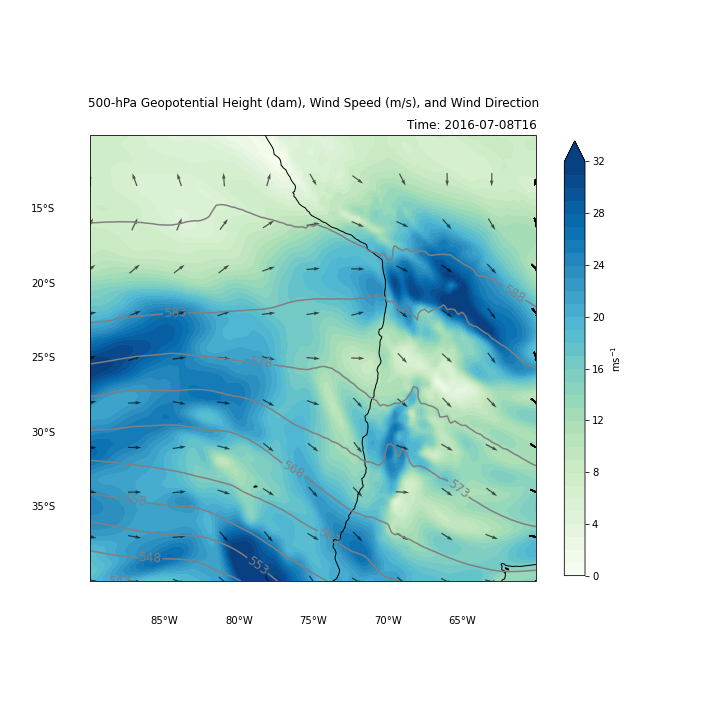

In [12]:
plot(500, '2016-07-08T16',t=0, steps=5, format_time=False)

In [13]:
#animate using gif: https://github.com/maxhumber/gif
gif.options.matplotlib["dpi"] = 300
i = 500
t = 0
frames = []
for j in ds.time.values[:7]:
    frame = plot(i, j, t, steps=5, format_time=True)
    if t == len(ds.time.values[:7]):
        break
    t += 1 
    frames.append(frame)

In [14]:
gif.save(frames, 'example.gif', duration=7, unit="s", between="startend")

In [15]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

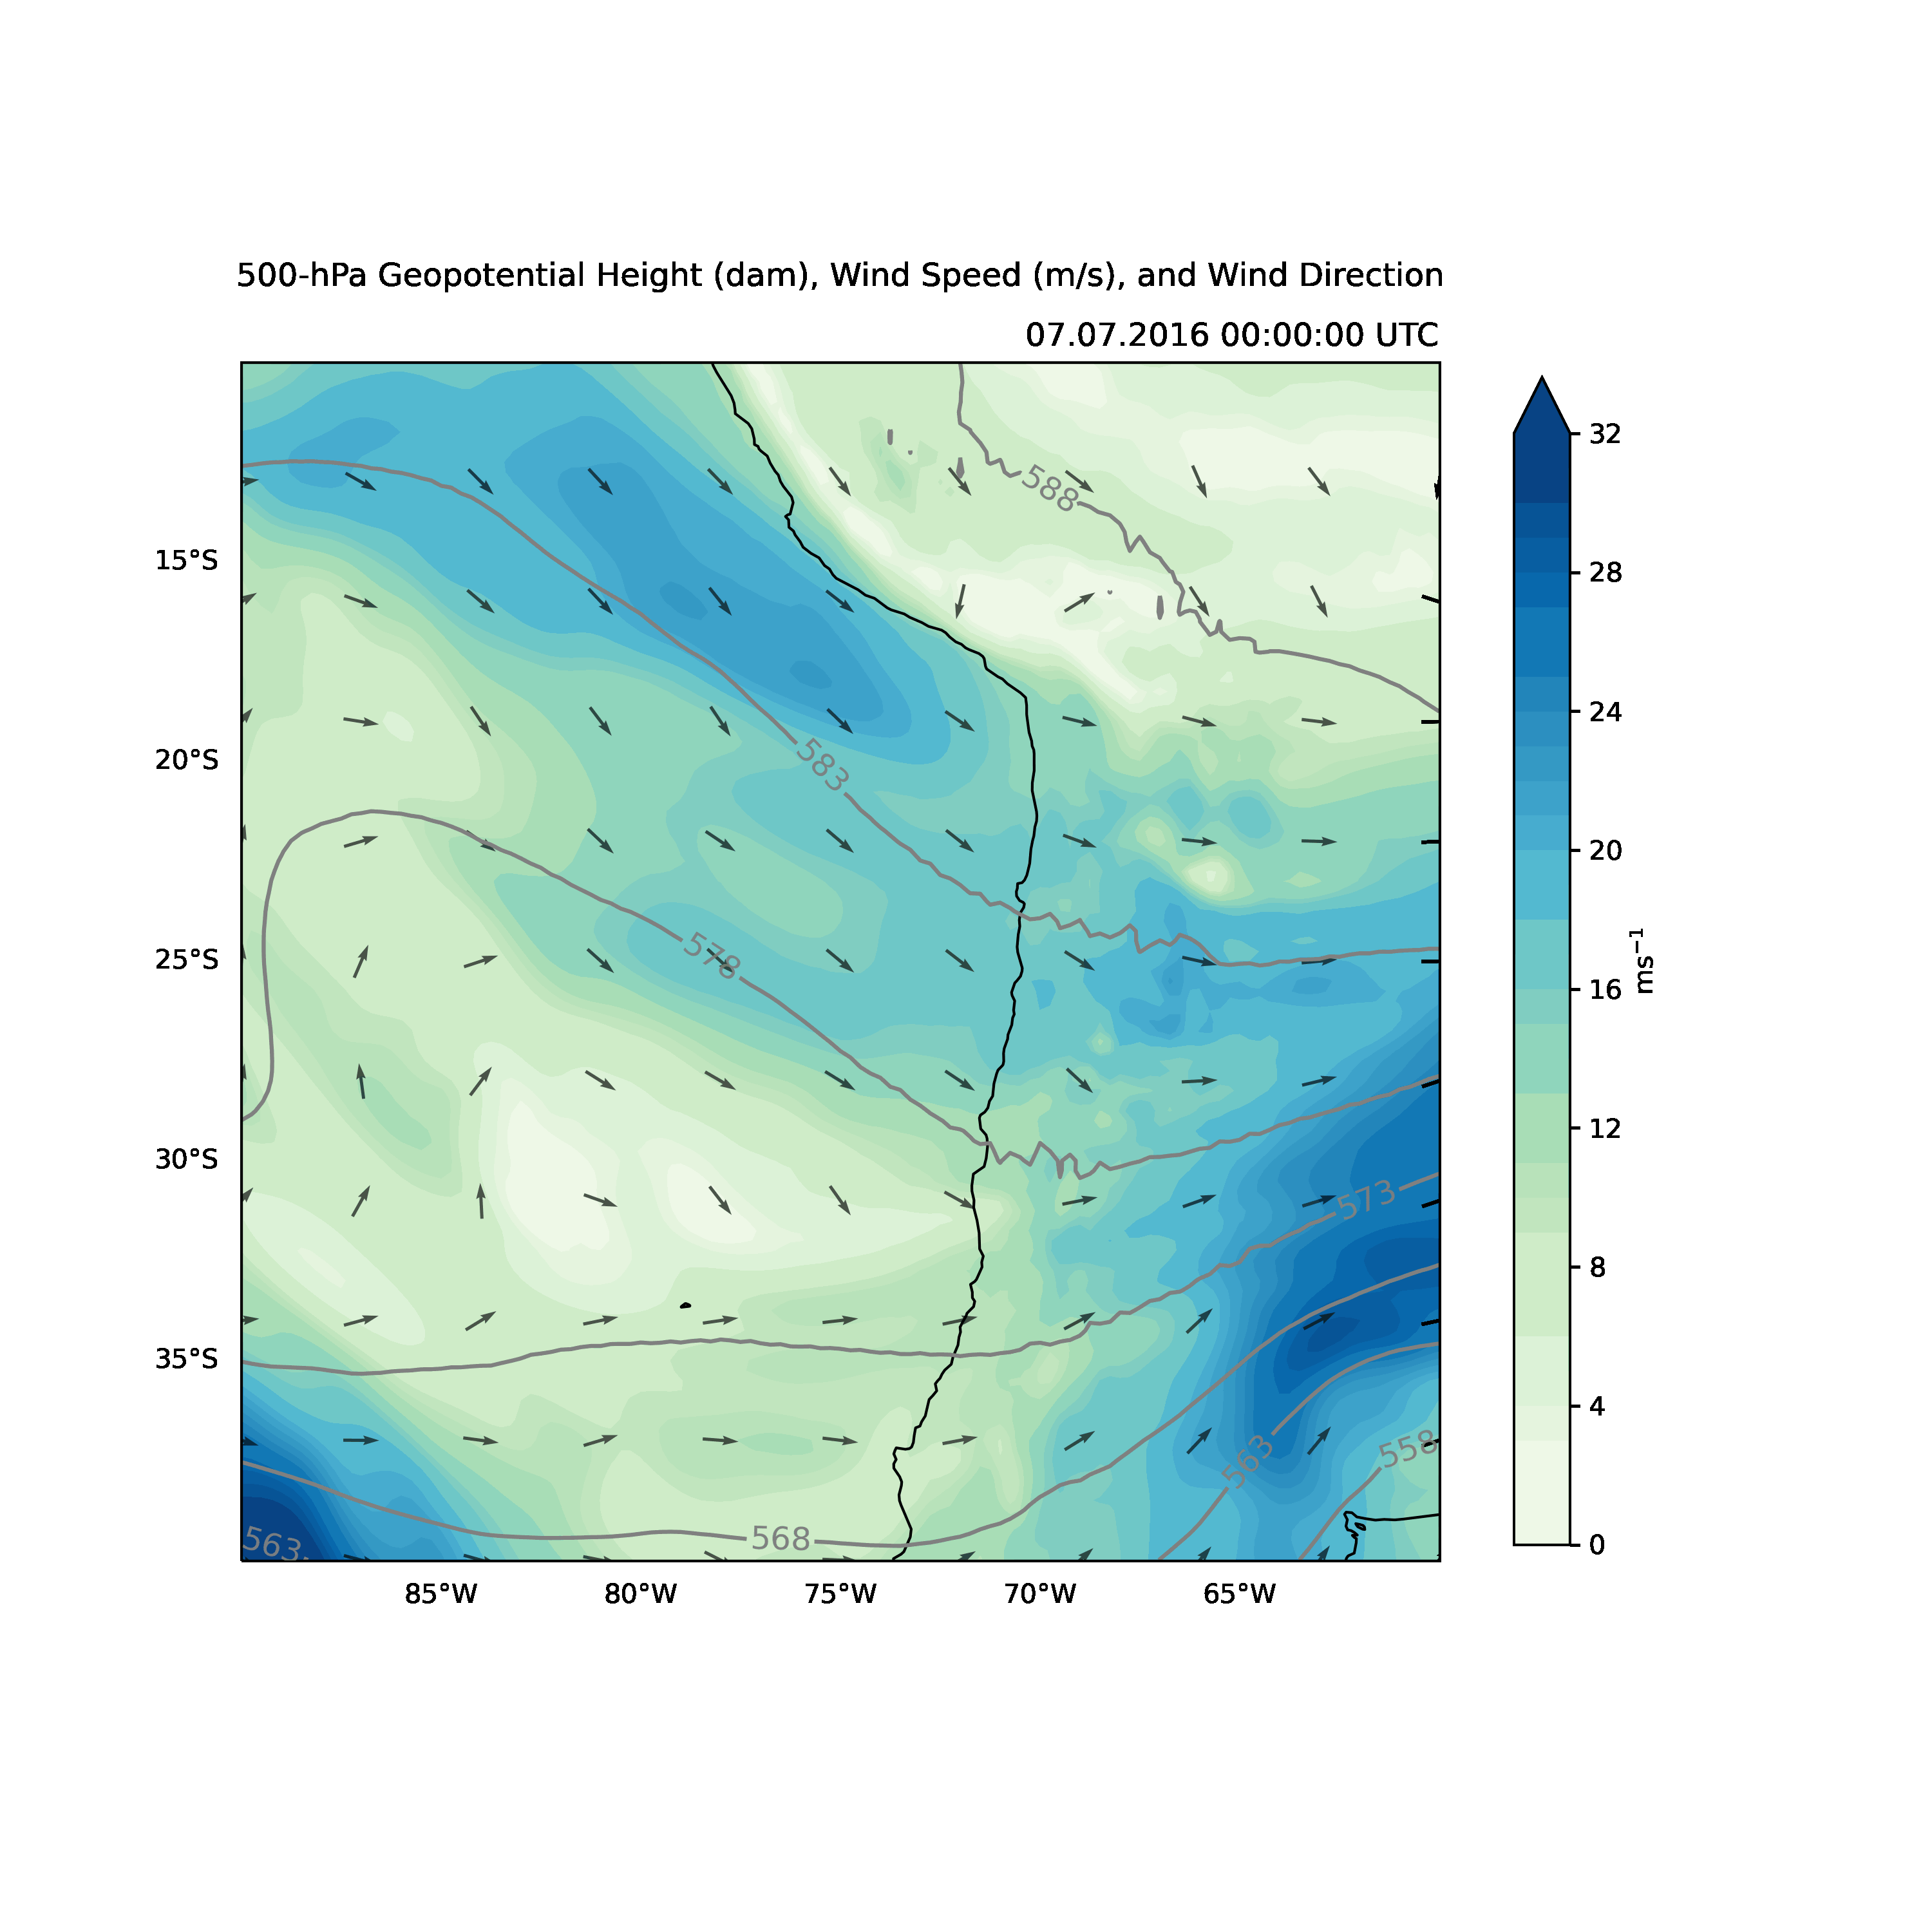

In [16]:
gifPath = Path("example.gif")
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')